# Error analysis for positional measurements with PSF fitting

We evaluate the expected errors in positional measurements with PSF fitting. The PSF data is stored as psf.fits in this directory. The PSF is modeled with considering only the aperture pattern and diffraction effects. Wavefront errors and attitude control errors are not considered. At first, we check the PSF data.

## Loading and plotting the data.

In [159]:
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import numpy as np

In [160]:
fits = pf.open("psf.fits")[0]

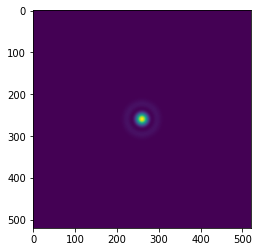

In [161]:
#plt.imshow(fits.data[250:270,250:270])
plt.imshow(fits.data)
plt.show()

In [162]:
fits.data.shape

(520, 520)

## Data settings.

In [163]:
M = 6320e3; p = 10e-6; EFL = 4860e-3;
CellPix = p/EFL*M
print(CellPix)

13.004115226337449


The CellPix parameter is set to this value (13). This means that 13 pixels in this psf.fits corresponds to a pixel in the detector.

## Making PSF image with the detector pixel gridding.

The loaded PSF image is not centered at a pixel center but centered between four pixels. Since we want to simulate a PSF image centered at a detector pixel, we divide a pixel into four pixels and rebinned them such that the resulted PSF image is centered at a pixel center.

In [12]:
psf2 = np.zeros(shape=(1040,1040))

In [21]:
psf2[0:1040:2,0:1040:2] = fits.data*0.25
psf2[1:1040:2,0:1040:2] = fits.data*0.25
psf2[0:1040:2,1:1040:2] = fits.data*0.25
psf2[1:1040:2,1:1040:2] = fits.data*0.25

In [32]:
psf3 = np.zeros(shape=(519,519))

In [33]:
for x in range(0,519):
    for y in range(0,519):
        psf3[y,x] = np.sum(psf2[1+2*y:1+2*y+2, 1+2*x:1+2*x+2])

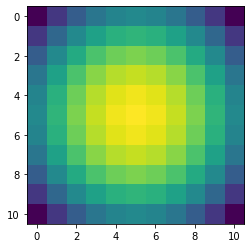

In [44]:
plt.imshow(psf3[259-5:259+6,259-5:259+6])

This is the rebinned image. the PSF center is located at the center of the central pixel.

By binning 13 pixels, we make a PSF data imaged by the detector.

In [164]:
psf4 = np.zeros(shape=(39,39))
for x in range(0,39):
    for y in range(0,39):
        psf4[y,x] = np.sum(psf3[6+13*y:6+13*y+13, 6+13*x:6+13*x+13])

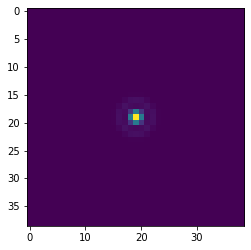

In [165]:
plt.imshow(psf4)

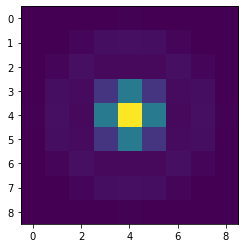

In [166]:
plt.imshow(psf4[15:24,15:24])

This is the 9x9-cutout PSF image on the detector. The unit is electrons/sec/pixel, and the magnitude is assumed to be 0 mag.

## Defining a function to make a detector image from the PSF data.

The procedure to make a PSF image observed by the detector was established as above. We make a function to perform the process as below. In this function, we allow to shift the PSF by dx and dy. The units of dx and dy are not the detector pixel but the pixel in the original PSF pixel (1/13 detector pixel).

In [167]:
def func(fits,dx=0,dy=0):
    psf0 = np.zeros(shape=(522,522))
    psf0[1:521,1:521] = fits.data
    
    psf1 = np.zeros(shape=(520,520))
    psf1[0:520,0:520] = psf0[1-dy:521-dy,
                             1-dx:521-dx]
    
    psf2 = np.zeros(shape=(1040,1040))
    psf2[0:1040:2,0:1040:2] = psf1*0.25
    psf2[1:1040:2,0:1040:2] = psf1*0.25
    psf2[0:1040:2,1:1040:2] = psf1*0.25
    psf2[1:1040:2,1:1040:2] = psf1*0.25
    
    psf3 = np.zeros(shape=(519,519))
    for x in range(0,519):
        for y in range(0,519):
            psf3[y,x] = np.sum(psf2[1+2*y:1+2*y+2, 1+2*x:1+2*x+2])
    
    psf4 = np.zeros(shape=(39,39))
    for x in range(0,39):
        for y in range(0,39):
            psf4[y,x] = np.sum(psf3[6+13*y:6+13*y+13, 6+13*x:6+13*x+13])
    
    return psf4[15:24,15:24]

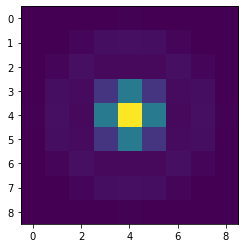

In [168]:
plt.imshow(func(fits,dx=0,dy=0))

This is the unshifted image.

In [169]:
img1 = func(fits, dx=0, dy=0)
img2 = func(fits, dx=1, dy=0)

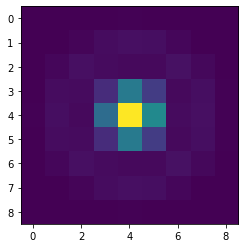

In [170]:
plt.imshow(img2)

This is a PSF image shifted by dx=1.

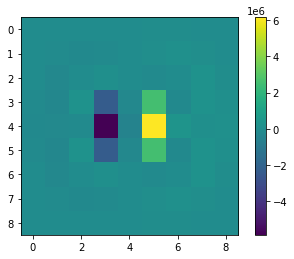

In [174]:
plt.imshow(img2-img1)
plt.colorbar()

This is the differential image. We can see that the image is actually shifted to right.

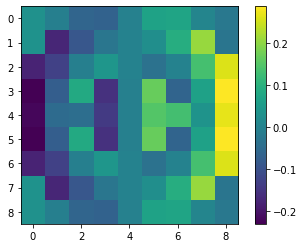

In [175]:
plt.imshow((img2-img1)/img1)
plt.colorbar()

This is the fractional map.

## Deriving the partial differential with respect to the center coordinates.

We need to know the partial differential of the pixel counts with respect to the PSF center coordinates. At first, we make PSF images slightly shifted to x and y directions.

In [180]:
img_dx00_dy00 = func(fits,dx=0,dy=0)
img_dxp1_dy00 = func(fits,dx=+1,dy=0)
img_dxm1_dy00 = func(fits,dx=-1,dy=0)
img_dx00_dyp1 = func(fits,dx=0,dy=+1)
img_dx00_dym1 = func(fits,dx=0,dy=-1)

The images are shifted by +1/-1 PSF pixels. The PSF pixel corresponds to 1/13 detector pixel. Based on this, we can derive the partial differentials as below:

In [181]:
dimg_dxc = (img_dxp1_dy00 - img_dxm1_dy00)/(2./13.)
dimg_dyc = (img_dx00_dyp1 - img_dx00_dym1)/(2./13.)

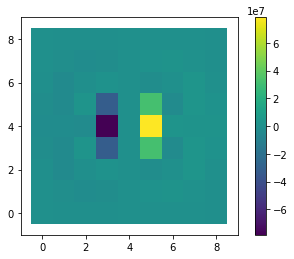

In [182]:
plt.imshow(dimg_dxc)
plt.xlim([-1,9])
plt.ylim([-1,9])
plt.colorbar()

This is $\partial N_\mathrm{ij}/\partial x_\mathrm{c}$, where $N_{\mathrm{ij}}$ is the counts of $(\mathrm{i}, \mathrm{j})$ pixel, and $x_\mathrm{c}$ is the $x$-coordinate of the PSF center.

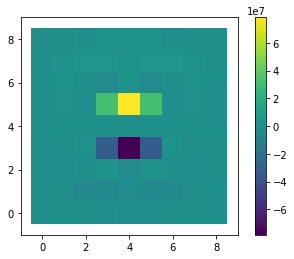

In [183]:
plt.imshow(dimg_dyc)
plt.xlim([-1,9])
plt.ylim([-1,9])
plt.colorbar()

This is $\partial N_\mathrm{ij}/\partial y_\mathrm{c}$, where $y_\mathrm{c}$ is the $y$-coordinate of the PSF center.

## Calculating the positional estimation error with PSF fitting.

If we perform least-square PSF fitting to estimate stellar positions, the positional estimation error can be calculated in the way described in the Yamada-san's documents (JASMINE-C3-TN-YY-002; JASMINE-C3-TN-YY-003) and Kataza-san's document (JASMINE-C2-TN-HKZ-20220117-01-check). We try to perform the calculation.

In [184]:
w = np.diag(1./img_dx00_dy00.flatten())

In this calculation, we consider only shot noise. The variance is given by each pixel count, which is stored in img_dx00_dy00 (unshifted image). We calculate $(X\sigma X^{T})^{-1}$ matrix described in Yamada-san's documents as $w$ shown above.

In [185]:
Amat = np.matrix(np.concatenate([[dimg_dxc.flatten()],[dimg_dyc.flatten()]]))

This array corresponds to $A^T$ in Yamada-san's documents.

In [186]:
np.sqrt((Amat*w*Amat.T).I)

matrix([[3.83557989e-05, 8.91379690e-13],
        [9.00276196e-13, 3.83789163e-05]])

This is the square root of $\Sigma$ matrix in Yamada-san's documents. The (0,0) and (1,1) elements corresponds to the uncertainties of the estimated $x_\mathrm{c}$ and $y_\mathrm{c}$, respectively. The units are detector pixels.

## Defining a function to calculate the estimation uncertainties.

The procedure to calculate the estimation uncertainties of the center coordinates was established above. We define a function to perform this calculation. In this function, we take into account the object magnitude and exposure time.

In [187]:
def func2(fits, mag, texp):
    img = fits.data*10.**(mag/(-2.5))*texp
    
    img_dx00_dy00 = func(img,dx=0,dy=0)
    img_dxp1_dy00 = func(img,dx=+1,dy=0)
    img_dxm1_dy00 = func(img,dx=-1,dy=0)
    img_dx00_dyp1 = func(img,dx=0,dy=+1)
    img_dx00_dym1 = func(img,dx=0,dy=-1)
    
    dimg_dxc = (img_dxp1_dy00 - img_dxm1_dy00)/(2./13.)
    dimg_dyc = (img_dx00_dyp1 - img_dx00_dym1)/(2./13.)
    
    w = np.diag(1./img_dx00_dy00.flatten())
    Amat = np.matrix(np.concatenate([[dimg_dxc.flatten()],[dimg_dyc.flatten()]]))
    err = np.sqrt((Amat*w*Amat.T).I)
    
    return err

In [188]:
print(func2(fits, 12.0, 12.5))

[[2.72505973e-03 2.97998936e-11]
 [2.85756143e-11 2.72670215e-03]]


This result means that the positional uncertainties are 2.7e-3 pixels for 12.0-mag object with 12.5-sec exposure. This calculation is based on only shot noise, and it seems to be almost consistent with the results shown in Kataza-san's document. If we consider the readout noise, dark current, and stray light, we have to modify $w$ matrix.

## Magnitude dependency of the estimation uncertainties.

In [189]:
mags = [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]
errs = []
texp = 12.5

for mag in mags:
    errs.append(func2(fits, mag, texp)[0,0])
errs = np.array(errs)

/home/kamizuka/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


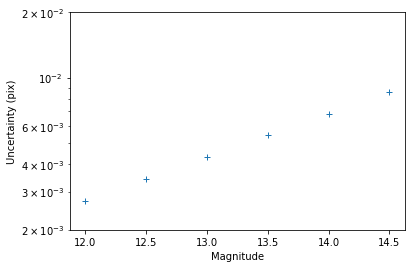

In [195]:
plt.plot(mags, errs, '+')
plt.xlabel('Magnitude')
plt.ylabel('Uncertainty (pix)')
plt.yscale('log')
plt.ylim([2e-3,2e-2])
plt.show()

## Considering dark current and stray light.

Dark current including stray light is assumed to be 24.5 electrons/sec/pixel in the current default parameter setting. We define a new function to calculate the positional uncertainties with considering the dark current and stray light.

In [202]:
def func2_wdark(fits, mag, texp, dark):
    img = fits.data*10.**(mag/(-2.5))*texp
    
    img_dx00_dy00 = func(img,dx=0,dy=0)
    img_dxp1_dy00 = func(img,dx=+1,dy=0)
    img_dxm1_dy00 = func(img,dx=-1,dy=0)
    img_dx00_dyp1 = func(img,dx=0,dy=+1)
    img_dx00_dym1 = func(img,dx=0,dy=-1)
    
    dimg_dxc = (img_dxp1_dy00 - img_dxm1_dy00)/(2./13.)
    dimg_dyc = (img_dx00_dyp1 - img_dx00_dym1)/(2./13.)
    
    w = np.diag(1./(img_dx00_dy00+dark*texp).flatten())
    Amat = np.matrix(np.concatenate([[dimg_dxc.flatten()],[dimg_dyc.flatten()]]))
    err = np.sqrt((Amat*w*Amat.T).I)
    
    return err

In [203]:
errs_wdark = []
dark = 24.5

for mag in mags:
    errs_wdark.append(func2_wdark(fits, mag, texp, dark)[0,0])
errs_wdark = np.array(errs_wdark)

/home/kamizuka/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


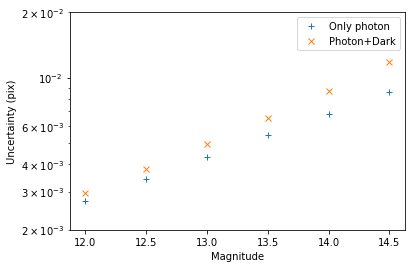

In [204]:
plt.plot(mags, errs, '+', label='Only photon')
plt.plot(mags, errs_wdark, 'x', label='Photon+Dark')
plt.xlabel('Magnitude')
plt.ylabel('Uncertainty (pix)')
plt.yscale('log')
plt.ylim([2e-3,2e-2])
plt.legend()
plt.show()

## Considering readnoise.

Readnoise is assumed to be 15 electrons/read in the current default parameter setting. We define a new function to calculate the positional uncertainties with considering the readnoise.

In [205]:
def func2_wdark_wrn(fits, mag, texp, dark, readnoise):
    img = fits.data*10.**(mag/(-2.5))*texp
    
    img_dx00_dy00 = func(img,dx=0,dy=0)
    img_dxp1_dy00 = func(img,dx=+1,dy=0)
    img_dxm1_dy00 = func(img,dx=-1,dy=0)
    img_dx00_dyp1 = func(img,dx=0,dy=+1)
    img_dx00_dym1 = func(img,dx=0,dy=-1)
    
    dimg_dxc = (img_dxp1_dy00 - img_dxm1_dy00)/(2./13.)
    dimg_dyc = (img_dx00_dyp1 - img_dx00_dym1)/(2./13.)
    
    readnoise2 = np.sqrt(2)*readnoise
    w = np.diag(1./(img_dx00_dy00+dark*texp+readnoise2**2.).flatten())
    Amat = np.matrix(np.concatenate([[dimg_dxc.flatten()],[dimg_dyc.flatten()]]))
    err = np.sqrt((Amat*w*Amat.T).I)
    
    return err

In [206]:
errs_wdark_wrn = []
readnoise = 15.

for mag in mags:
    errs_wdark_wrn.append(func2_wdark_wrn(fits, mag, texp, dark, readnoise)[0,0])
errs_wdark_wrn = np.array(errs_wdark_wrn)

/home/kamizuka/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


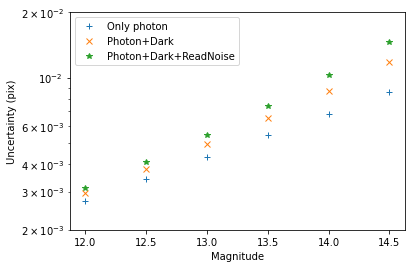

In [208]:
plt.figure(facecolor="white")
plt.plot(mags, errs, '+', label='Only photon')
plt.plot(mags, errs_wdark, 'x', label='Photon+Dark')
plt.plot(mags, errs_wdark_wrn, '*', label='Photon+Dark+ReadNoise')
plt.xlabel('Magnitude')
plt.ylabel('Uncertainty (pix)')
plt.yscale('log')
plt.ylim([2e-3,2e-2])
plt.legend()
plt.show()